# Library Import

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import six
from collections import namedtuple

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO

import numpy as np
import pandas as pd
from tqdm import tqdm

from torchvision.models import vgg16
from torchvision.ops import RoIPool
from torchvision.ops import nms

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils import data as data_

from torchnet.meter import ConfusionMeter, AverageValueMeter

# Util Functions

In [2]:
def loc2bbox(src_bbox, loc):
    """
    from src_bbox to dst bbox using loc
    Args:
        src_bbox: 소스 바운딩 박스
        loc: 델타
    Returns: dst_bbox
    """

    if src_bbox.shape[0] == 0:
        return np.zeros((0, 4), dtype=loc.dtype)

    src_bbox = src_bbox.astype(src_bbox.dtype, copy=False)

    # x_min, y_min, x_max, y_max
    src_height = src_bbox[:, 2] - src_bbox[:, 0]
    src_width = src_bbox[:, 3] - src_bbox[:, 1]
    src_ctr_y = src_bbox[:, 0] + 0.5 * src_height
    src_ctr_x = src_bbox[:, 1] + 0.5 * src_width

    dy = loc[:, 0::4]
    dx = loc[:, 1::4]
    dh = loc[:, 2::4]
    dw = loc[:, 3::4]

    ctr_y = dy * src_height[:, np.newaxis] + src_ctr_y[:, np.newaxis]
    ctr_x = dx * src_width[:, np.newaxis] + src_ctr_x[:, np.newaxis]
    h = np.exp(dh) * src_height[:, np.newaxis]
    w = np.exp(dw) * src_width[:, np.newaxis]

    dst_bbox = np.zeros(loc.shape, dtype=loc.dtype)
    dst_bbox[:, 0::4] = ctr_y - 0.5 * h
    dst_bbox[:, 1::4] = ctr_x - 0.5 * w
    dst_bbox[:, 2::4] = ctr_y + 0.5 * h
    dst_bbox[:, 3::4] = ctr_x + 0.5 * w

    return dst_bbox


def bbox2loc(src_bbox, dst_bbox):
    """
    src_bbox : 예측된 좌표값(or anchor), dst_bbox: gt 좌표값 -> loc(y, x, h, w)
    """

    # x_min, y_min, x_max, y_max
    height = src_bbox[:, 2] - src_bbox[:, 0]
    width = src_bbox[:, 3] - src_bbox[:, 1]
    ctr_y = src_bbox[:, 0] + 0.5 * height
    ctr_x = src_bbox[:, 1] + 0.5 * width

    # x_min, y_min, x_max, y_max
    base_height = dst_bbox[:, 2] - dst_bbox[:, 0]
    base_width = dst_bbox[:, 3] - dst_bbox[:, 1]
    base_ctr_y = dst_bbox[:, 0] + 0.5 * base_height
    base_ctr_x = dst_bbox[:, 1] + 0.5 * base_width

    eps = np.finfo(height.dtype).eps
    height = np.maximum(height, eps)
    width = np.maximum(width, eps)

    dy = (base_ctr_y - ctr_y) / height
    dx = (base_ctr_x - ctr_x) / width
    dh = np.log(base_height / height)
    dw = np.log(base_width / width)

    loc = np.vstack((dy, dx, dh, dw)).transpose()
    return loc


def normal_init(m, mean, stddev, truncated=False):
    """
    weight initialization
    """
    if truncated:
        m.weight.data.normal_().fmod_(2).mul_(stddev).add_(mean) 
    else:
        m.weight.data.normal_(mean, stddev)
        m.bias.data.zero_()


def get_inside_index(anchor, H, W):
    # Calc indicies of anchors which are located completely inside of the image
    # whose size is speficied.
    index_inside = np.where(
        (anchor[:, 0] >= 0) &
        (anchor[:, 1] >= 0) &
        (anchor[:, 2] <= H) &
        (anchor[:, 3] <= W)
    )[0]
    return index_inside


def unmap(data, count, index, fill=0):
    # Unmap a subset of item (data) back to the original set of items (of size count)
    if len(data.shape) == 1:
        ret = np.empty((count,), dtype=data.dtype)
        ret.fill(fill)
        ret[index] = data
    else:
        ret = np.empty((count,) + data.shape[1:], dtype=data.dtype)
        ret.fill(fill)
        ret[index, :] = data
    return ret


## util ##
def tonumpy(data):
    if isinstance(data, np.ndarray):
        return data
    if isinstance(data, torch.Tensor):
        return data.detach().cpu().numpy()

def totensor(data, cuda = True):
    if isinstance(data, np.ndarray):
        tensor = torch.from_numpy(data)
    if isinstance(data, torch.Tensor):
        tensor = data.detach()
    if cuda:
        tensor = tensor.cuda()
    return tensor

def scalar(data):
    if isinstance(data, np.ndarray):
        return data.reshape(1)[0]
    if isinstance(data, torch.Tensor):
        return data.item()

# Main

### 하이퍼 파라미터 세팅

In [13]:
epochs=14
learning_rate = 1e-3
lr_decay = 0.1
weight_decay = 0.0005
use_drop = False   # use dropout in RoIHead

rpn_sigma = 3.     # sigma for l1_smooth_loss (RPN loss)
roi_sigma = 1.     # sigma for l1_smooth_loss (ROI loss)

data_dir = '/opt/ml/detection/dataset'   # 데이터 경로 


### Dataset 만들기

#### 1. custom data 불러 오기

In [14]:
# TrainDataset
class TrainCustom(Dataset):
    def __init__(self, annotation, data_dir, transforms = False):
        """
        Args:
            annotation: annotation 파일 위치
            data_dir: data가 존재하는 폴더 경로
            transforms : transform or not
        """

        super().__init__()
        self.data_dir = data_dir
        # coco annotation 불러오기 (coco API)
        self.coco = COCO(annotation)
        self.transforms = transforms

    def __getitem__(self, index: int):
        
        # 이미지 아이디 가져오기
        image_id = self.coco.getImgIds(imgIds=index)

        # 이미지 정보 가져오기
        image_info = self.coco.loadImgs(image_id)[0]

        # 이미지 로드
        image = cv2.imread(os.path.join(self.data_dir, image_info['file_name']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 어노테이션 파일 로드
        ann_ids = self.coco.getAnnIds(imgIds=image_info['id'])
        anns = self.coco.loadAnns(ann_ids)

        # 박스 가져오기
        boxes = np.array([x['bbox'] for x in anns])

        # boxes (x_min, y_min, x_max, y_max)
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

        # 레이블 가져오기
        labels = np.array([x['category_id'] for x in anns])
        labels = torch.as_tensor(labels, dtype=torch.int64)

        sample = {
            'image': image,
            'bboxes': boxes,
            'labels': labels
        }

        bboxes = torch.tensor(sample['bboxes'], dtype=torch.float32)
        boxes = torch.tensor(sample['bboxes'], dtype=torch.float32)

        # bboxes (x_min, y_min, x_max, y_max) -> boxes (y_min, x_min, y_max, x_max)
        boxes[:, 0] = bboxes[:, 1]
        boxes[:, 1] = bboxes[:, 0]
        boxes[:, 2] = bboxes[:, 3]
        boxes[:, 3] = bboxes[:, 2]

        return image, boxes, labels

    def __len__(self) -> int:
        return len(self.coco.getImgIds())


In [15]:
import matplotlib.pyplot as plt
annotation = os.path.join('/opt/ml/detection/dataset/easy_train_modified_5.json')
dataset = TrainCustom(annotation, data_dir, transforms=True)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [16]:
def CalSize(coord: list):
    if len(coord) != 4:
        raise Exception(len(coord))
    y_min, x_min, y_max, x_max = coord
    return (x_max-x_min)*(y_max-y_min)

In [17]:
def wasd(coord: list):
    if len(coord) != 4:
        raise Exception(len(coord))
    BASESIZE=1024 // 2
    y_min, x_min, y_max, x_max = coord
    Lx, Ly = [(x_max-x_min) / 2, (y_max-y_min) / 2]
    mx, my = x_min + Lx, y_min + Ly
    if mx <= BASESIZE and my <= BASESIZE:   #1
        return 0
    elif mx > BASESIZE and my <= BASESIZE:   #1
        return 1
    elif mx <= BASESIZE and my > BASESIZE:   #1
        return 2
    elif mx > BASESIZE and my > BASESIZE:   #1
        return 3
    else:
        raise Exception('wtf?')

In [18]:
#레이블 간 연관성
def relation(labels: list):
    return [True if i in labels else False for i in range(10)]

In [23]:
#크기 비율(10% 단위), 상하편향, 좌우편향, 레이블 갯수
from collections import defaultdict
from tqdm import tqdm
label_count = defaultdict(int)
thing_count = defaultdict(int)
sizelist = []
middledict = {0:0, 1:0, 2:0, 3:0}
rows = []

for i in tqdm(range(len(dataset))):
    try:
        _, bbox, labels = dataset[i]
    except:
        continue
    bbox, labels = bbox.tolist(), labels.tolist()
    thing_count[len(labels)] += 1
    # bbox: list of (x_min, y_min, x_max, y_max)
    sizelist.append(sum([CalSize(coord) for coord in bbox]) / len(labels))
    
    box_middle = [wasd(coord) for coord in bbox]
    for m in box_middle:
        middledict[m] += 1
    for lab in labels:
        label_count[lab] += 1
        
    rows.append(relation(labels))

100%|██████████| 3645/3645 [00:46<00:00, 78.66it/s] 


<BarContainer object of 4 artists>

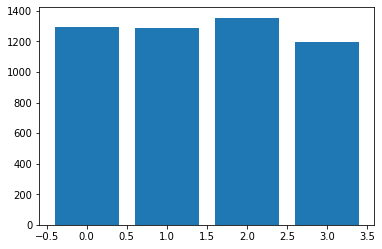

In [24]:
plt.bar(middledict.keys(), middledict.values())

<BarContainer object of 10 artists>

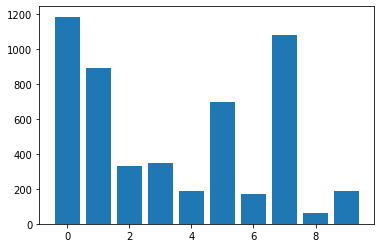

In [25]:
s_labelcount = dict(sorted(label_count.items(), key = lambda i: i[0]))
plt.bar(s_labelcount.keys(), s_labelcount.values())

Text(1024000, 100, 'maxsize')

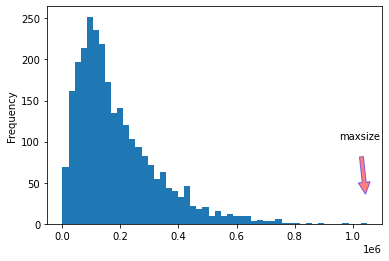

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import numpy as np

#박스크기평균(1 이미지당)
fig, ax = plt.subplots()
series = pd.Series(sizelist)
series.plot(kind='hist', bins=50, ax=ax)
plt.annotate('maxsize',
    ha = 'center', va = 'bottom',
    xytext = (1024*1000, 100),
    xy = (1024*1024, 20),
    arrowprops = { 'facecolor' : 'r', 
                  'edgecolor':'b', 
                  'shrink' : 0.2, 
                  'alpha':0.5})

<BarContainer object of 5 artists>

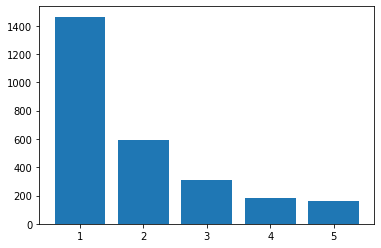

In [27]:
#이미지 내 객체의 갯수
s_thing_count = dict(sorted(thing_count.items(), key = lambda i: i[0]))
plt.bar(s_thing_count.keys(), s_thing_count.values())
#max 71, min 1

In [28]:
pd.DataFrame(np.array(rows), columns = [x for x in range(10)]).corr().style.background_gradient(cmap='coolwarm').set_precision(2)

In [29]:
label_string_dict = {
    0: "General trash",
    1:"Paper",
    2: "Paper pack", 
    3:"Metal",
    4: "Glass",
    5: "Plastic",
    6: "Styrofoam",
    7: "Plastic bag",
    8: "Battery",
    9: "Clothing",
    }

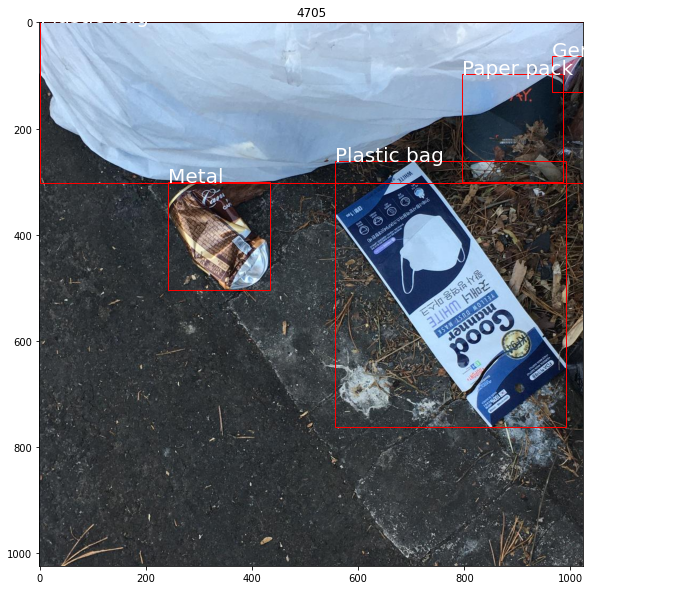

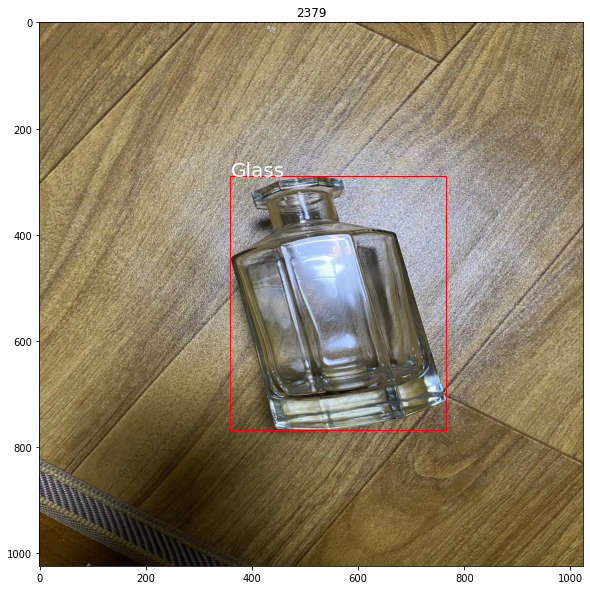

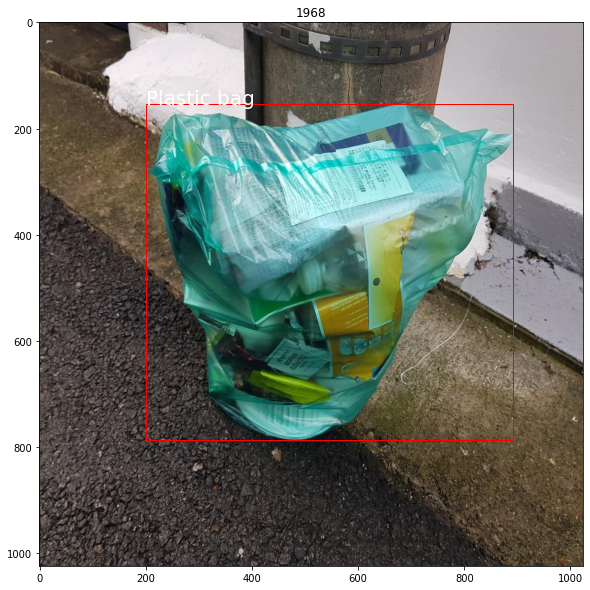

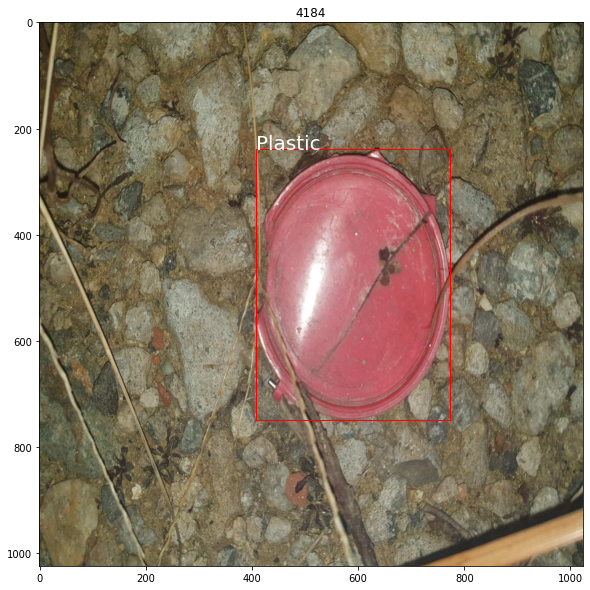

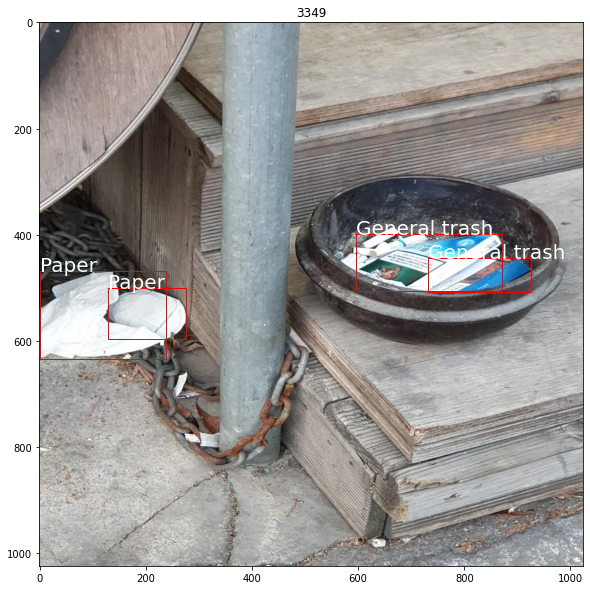

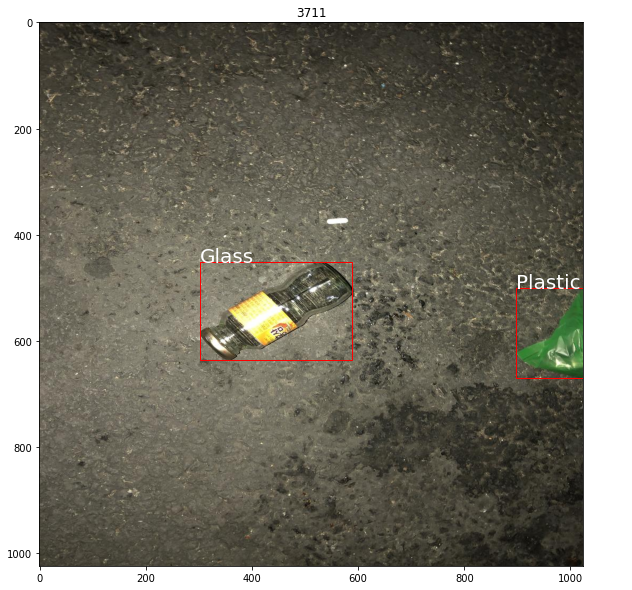

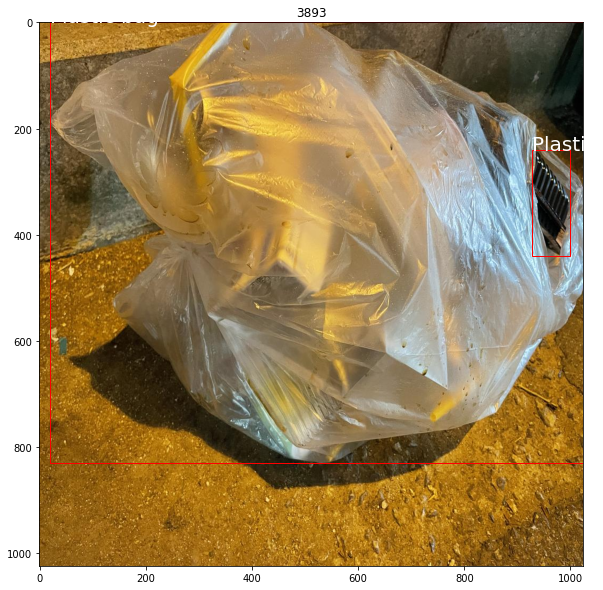

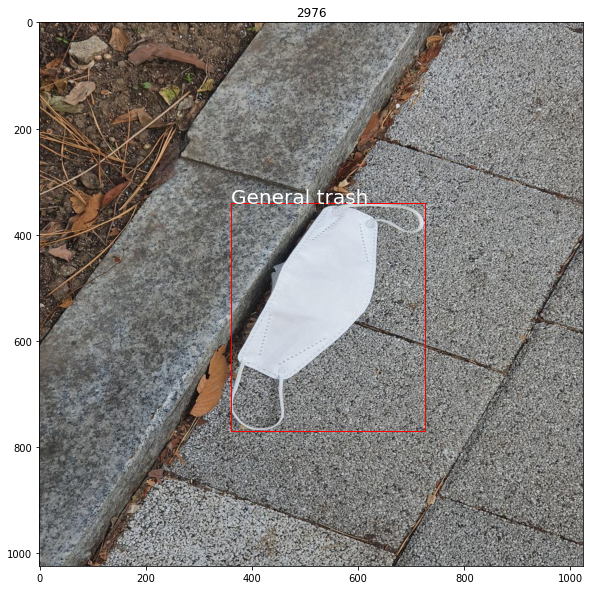

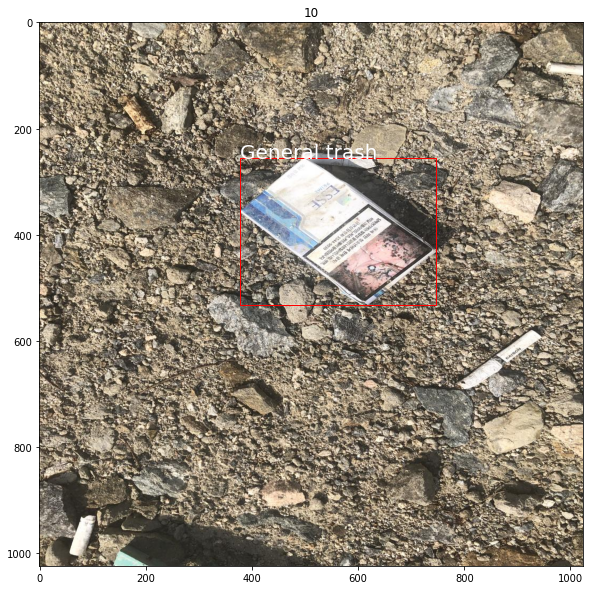

In [36]:
#시각화
import random
from PIL import Image
import matplotlib.patches as patches
n_images = 10
idxs = random.sample(list(range(4883)), n_images)


for c, idx in enumerate(idxs):
    try:
        image, bbox, labels = dataset[idx]
    except:
        continue
        
    # if 8 not in labels:
    #     continue
        
    fig, ax = plt.subplots(figsize=(10,10))
    bbox, labels = bbox.tolist(), labels.tolist()
    assert len(bbox) == len(labels)

    ax.imshow(image)
    
    for coord, label in zip(bbox, labels):
        y_min, x_min, y_max, x_max = coord
        ax.add_patch(
             patches.Rectangle(
                (x_min, y_min),
                 
                x_max-x_min,
                y_max-y_min,
                
                edgecolor = 'red',
                facecolor = 'red',
                fill=False
             ) )
        
        ax.text(x_min, y_min, label_string_dict[label], fontsize=20, color='w', fontweight=200)
        ax.set_title(idx)
    plt.show()

In [91]:
c

0

In [94]:
1%4

1